[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import json

/tmp/ipykernel_4034305/3059525336.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [15]:
#Import the geometry, mesh and fixed node info
f = open('Envelope.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)


f.close()

df = data['faces'] #Connectivity matrix
faces = np.array(df) #convert to numpy array
df2 = data['vertices'] #Coordinate
crd = np.array(df2) #convert to numpy array
df3 = data['vertex_is_red'] #Connectivity matrix
fixed_nodes = np.where(df3)[0] #convert to numpy array

#From faces to frames
import trimesh
mesh = trimesh.load('Envelope.ply')

cnct  = np.array(mesh.edges_unique)

In [5]:
#Normalize the coordinates
x_nodes = 3*crd[:,0]-min(crd[:,0])
y_nodes = 3*crd[:,1]-min(crd[:,1])
z_nodes = 3*crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

In [16]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
      design_nodes.append(i)

fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

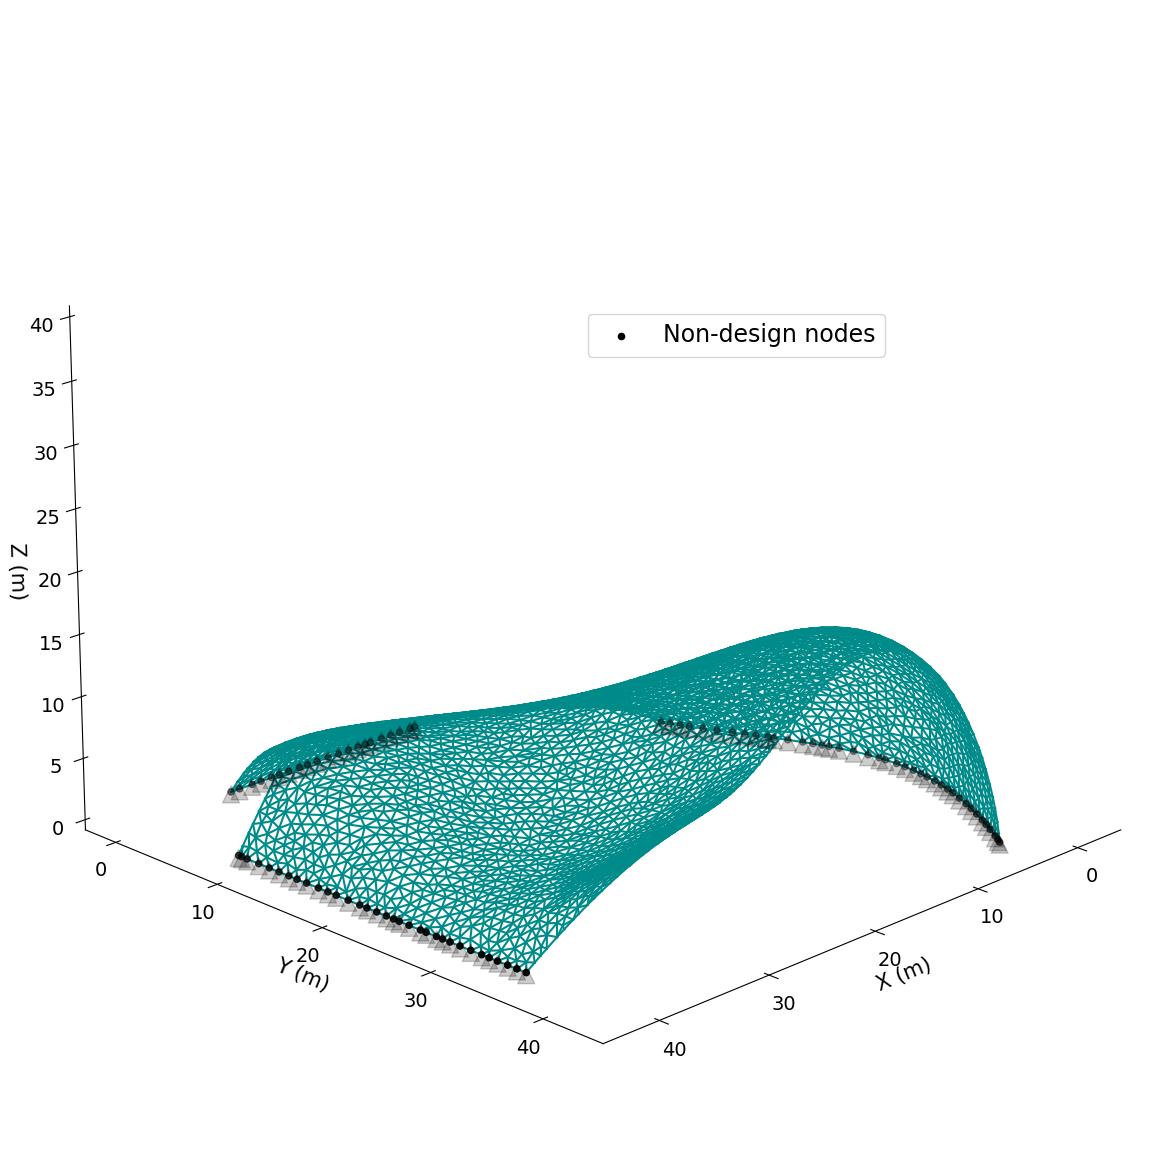

In [17]:

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [18]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))
#Matrix storing XY-projected distance  
dx_ij = x_nodes[:,None]-x_nodes[None,:]
dy_ij = y_nodes[:,None]-y_nodes[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,10)


#This does not impose any constraints on the boundary nodes.
#We apply soft constraints - increasing the weights of boundary
alpha = 1 # coefficient adujsting the weights for boundary
B_ij_ini[:,non_design_nodes] *= alpha
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(x_nodes.shape[0]).reshape(x_nodes.shape[0],x_nodes.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [19]:
zs_filtered = z_nodes.copy()
zs_filtered =(B_ij@zs_filtered)#[design_nodes]

In [20]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle
h = 0.2 #height
b = 0.1 #width
E = 37900 * 10**5 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = 0.001*b*h**3/12 #Moement of inertia in m^4
Iz = 0.001*h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area
load = -10 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 


In [21]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [22]:
%timeit sso_model.value_grad_params(which_solver='dense',enforce_scipy_sparse = True)

368 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
def objective_filter(x,sso_model=sso_model):
    p = z_nodes.copy()
    p[design_nodes]=x
    z = (B_ij@p)[design_nodes]
    sso_model.update_nodeparameter(z) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='dense',enforce_scipy_sparse = True)
    return C,np.asarray((sens@B_ij[design_nodes])[design_nodes],dtype=float)#sens_params

In [24]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = sso_model.nodeparameters_values #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective_filter) #objective function
opt.set_maxiter(150) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 63116.400806068414
Step 1, objective = 57581.63787629256
Step 2, objective = 52514.86017196209
Step 3, objective = 47933.3141307507
Step 4, objective = 43860.68198182709
Step 5, objective = 40297.9691531461
Step 6, objective = 37164.04129584998
Step 7, objective = 34389.294284267875
Step 8, objective = 31922.575890387823
Step 9, objective = 29724.192218378823
Step 10, objective = 27758.89912074621
Step 11, objective = 25993.179923171672
Step 12, objective = 24395.421968488234
Step 13, objective = 22948.761418745562
Step 14, objective = 21665.25631133862
Step 15, objective = 20513.421665133785
Step 16, objective = 19470.701687518478
Step 17, objective = 18520.9450021771
Step 18, objective = 17651.85589754676
Step 19, objective = 16853.22342317045
Step 20, objective = 16116.123762194513
Step 21, objective = 15432.799105363123
Step 22, objective = 14796.778237741955
Step 23, objective = 14202.942754416707
Step 24, objective = 13647.434260438413
Step 25, objective = 131

In [25]:
z_nodes[design_nodes] = x_opt
zs_filtered = z_nodes.copy()
zs_filtered[design_nodes] =(B_ij@z_nodes)[design_nodes]

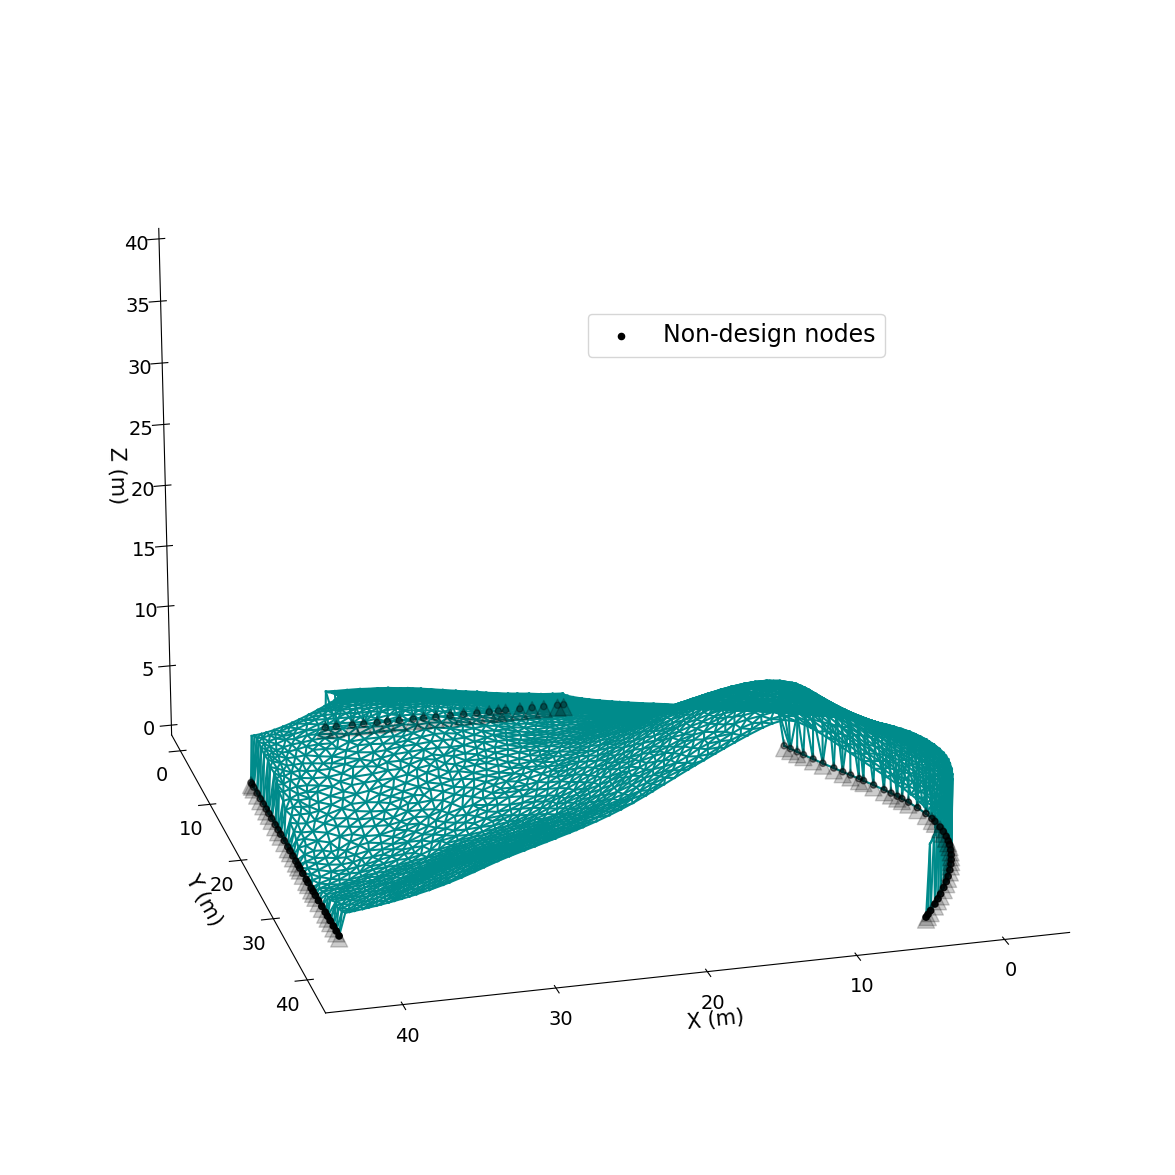

In [26]:
#Update the nodes
%matplotlib inline

z_ele[:,0] = zs_filtered[cnct[:,0]]
z_ele[:,1] = zs_filtered[cnct[:,1]]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, 75)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

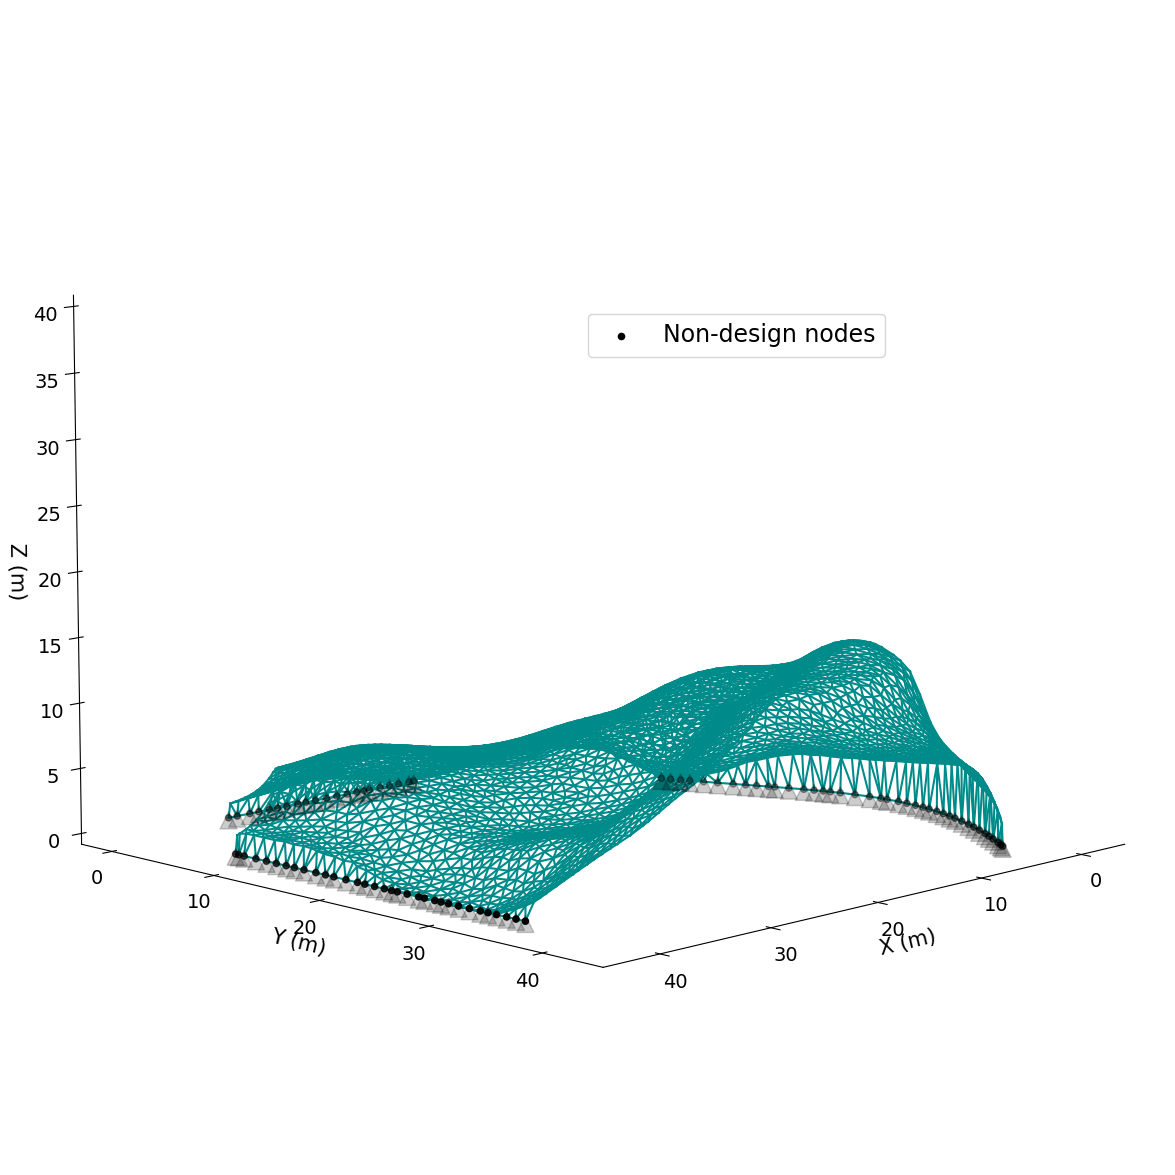

In [56]:
#Update the nodes
%matplotlib inline

z_ele[:,0] = zs_filtered[cnct[:,0]]
z_ele[:,1] = zs_filtered[cnct[:,1]]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, 45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()